In [1]:
import pystan
import pickle
import pandas as pd
from hashlib import md5
from shapely.wkt import loads
import arviz as az
%load_ext jupyterstan
%matplotlib inline

# az.style.use('arviz-darkgrid')

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
STAN_MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, "stan_models")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [15]:
# 将编译好的模型，存储成pickle，供直接使用
def StanModel_cache(model_code,, **kwargs):
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'cached-model-{}.pkl'.fromat(code_hash)
    else:
        cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn,'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm           

In [2]:
%%stan spectrum
functions {
  matrix cov_matern(vector[] x, real sigma, real fai, int upsilon) {
    int N=size(x);
    real dist;
    matrix[N, N] cov; 
    for (j in 1:N) 
      for (i in j:N) {
        dist = distance(x[i], x[j]);
        if (dist==0)
            cov[i,j] = 1;
        else 
           cov[i, j] = ((sigma ^ 2) / (2^(upsilon - 1) * tgamma(upsilon)))
          *((fai * dist) ^ upsilon) * modified_bessel_second_kind(upsilon, fai * dist);
      cov[j, i] = cov[i, j];
      }
    return cov;
  }
}

data {
  int<lower=1> N; //节点个数
  vector[N] recv_x;
  vector[N] recv_y;
  vector[N] Y;
  real gamma; //自由空间传播损耗因子
}

transformed data {
  vector[2] recv_coord[N]; //感知节点的坐标,长度为N的array，每个元素是一个二维向量
  for (i in 1:N) {
    recv_coord[i] = [recv_x[i], recv_y[i]]';
  }
}

parameters {
  real<lower=0> tran_power; //信号源发送功率
  real tran_x; //信号源坐标
  real tran_y;
  real<lower=0> sigma_epsilon; //测量误差
  real sigma_eta; // 空间方差
  real fai;  // matern 协方差函数
}
transformed parameters {

}

model {
  /* 指定先验分布 */
  vector[2] tran_coord;
  vector[N] dist_tran_recv;
  matrix[N,N] Sigma;
  vector[N] L;
  vector[N] mu;
  matrix[N, N] cov_sigma_epsilon;
  vector[N] i_vec = rep_vector(1.0, N);
  matrix[N, N] unit_matrix = diag_matrix(i_vec);
  int upsilon = 2; // smoothness parameter
  tran_power ~ normal(0, 100);
  tran_x ~ uniform(0, 500);
  tran_y ~ uniform(-500, 0);
  sigma_epsilon ~ inv_gamma(2, 10);
  sigma_eta ~ inv_gamma(2, 10);
  fai ~ uniform(1, 100);
  // upsilon ~ uniform(1, 100);   //FIX_IT
  tran_coord = [tran_x, tran_y]';
  for (i in 1:N) {
    dist_tran_recv[i] = distance(recv_coord[i], tran_coord);
  }
  Sigma = cov_matern(recv_coord, sigma_eta, fai, upsilon);
  L ~ multi_normal(rep_vector(0, N), Sigma);
  mu = tran_power - 10 * gamma * log10(dist_tran_recv) + L;
  cov_sigma_epsilon = sigma_epsilon * unit_matrix;
  Y ~ multi_normal(mu,cov_sigma_epsilon);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL spectrum_280cddee09b2e086abc73226263faa91 NOW.


Creating pystan model & assigning it to variable name "spectrum".
Stan options:
 {'model_name': 'spectrum', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "spectrum"!
Compilation took a minute.


In [21]:
%%stan spectrum_nn
functions {
  matrix cov_matern(vector[] x, real sigma, real fai, int upsilon) {
    int N=size(x);
    real dist;
    matrix[N, N] cov; 
    for (j in 1:N) 
      for (i in j:N) {
        dist = distance(x[i], x[j]);
        if (dist==0)
            cov[i,j] = 1;
        else 
           cov[i, j] = ((sigma ^ 2) / (2^(upsilon - 1) * tgamma(upsilon)))
          *((fai * dist) ^ upsilon) * modified_bessel_second_kind(upsilon, fai * dist);
      cov[j, i] = cov[i, j];
      }
    return cov;
  }
}

data {
  int<lower=1> N; //节点个数
  vector[N] recv_x;
  vector[N] recv_y;
  vector[N] Y;
  real gamma; //自由空间传播损耗因子
}

transformed data {
  vector[2] recv_coord[N]; //感知节点的坐标,长度为N的array，每个元素是一个二维向量
  for (i in 1:N) {
    recv_coord[i] = [recv_x[i], recv_y[i]]';
  }
}

parameters {
  real tran_power; //信号源发送功率
  real tran_x; //信号源坐标
  real tran_y;
  real sigma_eta; // 空间方差
  real fai;  // matern 协方差函数
}
transformed parameters {

}

model {
  
  vector[2] tran_coord;
  vector[N] dist_tran_recv;
  matrix[N,N] Sigma;
  vector[N] i_vec = rep_vector(1.0, N);
  matrix[N, N] unit_matrix = diag_matrix(i_vec);
  int upsilon = 2; // smoothness parameter
  
  /* 指定先验分布 */
  tran_power ~ normal(0, 100);
  tran_x ~ uniform(25, 475);
  tran_y ~ uniform(-475, -25);
  sigma_eta ~ inv_gamma(2, 10);
  fai ~ uniform(1, 100);
  
  tran_coord = [tran_x, tran_y]';
  for (i in 1:N) {
    dist_tran_recv[i] = distance(recv_coord[i], tran_coord);
  }
  Sigma = cov_matern(recv_coord, sigma_eta, fai, upsilon);
  Y ~ multi_normal(tran_power - 10 * gamma * log10(dist_tran_recv), Sigma);  
}

Creating pystan model & assigning it to variable name "spectrum_nn".
Stan options:
 {'model_name': 'spectrum_nn', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}


INFO:pystan:COMPILING THE C++ CODE FOR MODEL spectrum_nn_ae27388d71c184889d5671d6711ad68f NOW.


StanModel now available as variable "spectrum_nn"!
Compilation took a minute.


In [3]:
data = pd.read_csv("./rec_power_of_100_regular_pt.csv")

In [4]:
trans_x = lambda point:loads(point).x
trans_y = lambda point:loads(point).y

In [5]:
data.head(5)

,id,rec_coord,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
0,0,POINT(25 -25),-64.872220,-68.711005,-50.671022,-55.754878,-57.153839,-63.039914,-71.676997,-48.657067,...,-54.508552,-64.851959,-54.507002,-58.534489,-42.842244,-54.389202,-65.460837,-64.060099,-67.581948,-76.289185
1,1,POINT(75 -25),-60.888493,-69.483111,-64.143213,-66.968675,-45.674582,-52.592268,-50.790745,-60.063257,...,-52.509448,-58.096135,-40.563483,-72.555376,-74.246784,-50.756782,-59.075580,-67.820131,-50.719012,-61.177707
2,2,POINT(125 -25),-66.846345,-56.521142,-57.551924,-75.846260,-51.732423,-62.797498,-67.282280,-50.766463,...,-45.651759,-49.935558,-49.681506,-47.925547,-58.504376,-54.995596,-52.492948,-57.881466,-54.544753,-45.318933
3,3,POINT(175 -25),-56.985513,-59.271615,-50.541058,-61.405976,-51.479353,-38.494331,-52.594033,-46.587783,...,-51.730328,-53.177044,-49.169152,-63.262810,-59.265588,-60.537114,-58.098599,-58.150854,-59.183241,-58.111142
4,4,POINT(225 -25),-64.066679,-54.497503,-53.485396,-54.274303,-64.601527,-39.178391,-63.816451,-56.287949,...,-36.242244,-50.678535,-63.580355,-65.321044,-52.257230,-50.580103,-58.239698,-67.542019,-66.252606,-63.032889


In [6]:
# int<lower=1> N; //节点个数
#  vector[N] recv_x;
#  vector[N] recv_y;
#  vector[N] Y;
#  real gamma; //自由空间传播损耗因子
spectrum_data = {'N':100,
                 'recv_x':list(data['rec_coord'].map(trans_x)),
                 'recv_y':list(data['rec_coord'].map(trans_y)),
                 'Y':list(data.iloc[:, 3]),
                 'gamma':3.5}
print(spectrum_data)

{'N': 100, 'recv_x': [25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0, 25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0, 25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0, 25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0, 25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0, 25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0, 25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0, 25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0, 25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0, 25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 325.0, 375.0, 425.0, 475.0], 'recv_y': [-25.0, -25.0, -25.0, -25.0, -25.0, -25.0, -25.0, -25.0, -25.0, -25.0, -75.0, -75.0, -75.0, -75.0, -75.0, -75.0, -75.0, -75.0, -75.0, -75.0, -125.0, -125.0, -125.0, -125.0, -125.0, -125.0, -125.0, -125.0, -125.0, -125.0, -175.0, -175.0, -175.0, -175.0, -175.0, -175.0, -175.0, -175.0, -1

In [48]:
fit = spectrum_nn.sampling(data=spectrum_data, iter=10000, chains=4,init=[{'tran_x':124,'tran_y':-233,
                                                                          'sigma_eta':0.5,'fai':20},{'tran_x':124,'tran_y':-233,
                                                                          'sigma_eta':0.5,'fai':20},{'tran_x':124,'tran_y':-233,
                                                                          'sigma_eta':0.5,'fai':20},{'tran_x':124,'tran_y':-233,
                                                                          'sigma_eta':0.5,'fai':20}],
                           control={'adapt_delta':0.9})

In [ ]:
fit2 = spectrum_nn.sampling(data=spectrum_data, iter=10000, chains=1,init=[{'tran_x':124,'tran_y':-233,
                                                                          'sigma_eta':0.5,'fai':20}],
                           control={'adapt_delta':0.9})

In [45]:
print(fit2.stansummary())

Inference for Stan model: spectrum_nn_ae27388d71c184889d5671d6711ad68f.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tran_power   30.9  4.1e-3    0.1   30.7  30.83   30.9  30.96   31.1    636    1.0
tran_x     213.59    0.04   1.03  211.7 212.87 213.54 214.28 215.69    820    1.0
tran_y     -317.6    0.05   1.37 -320.5 -318.5 -317.5 -316.6 -315.1    676    1.0
sigma_eta    9.28    0.52   8.95   1.72   3.81   6.16  11.39  36.21    301    1.0
fai         49.48    1.35  29.24   2.88  23.56  49.21  74.97  97.63    469    1.0
lp__        -2836    0.08   1.73  -2840  -2836  -2835  -2834  -2833    498    1.0

Samples were drawn using NUTS at Wed Dec  4 12:16:26 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


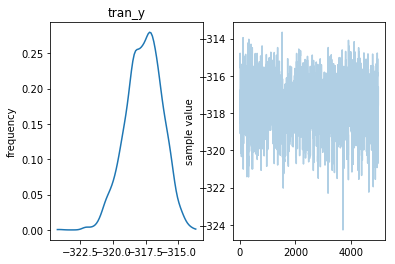

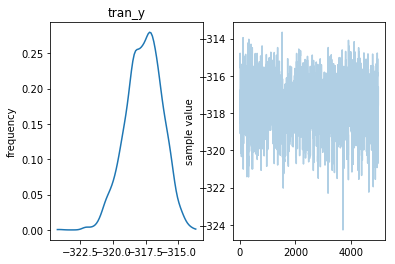

In [46]:
fit2.plot(pars="tran_y") 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c266a3630>,
      dtype=object)

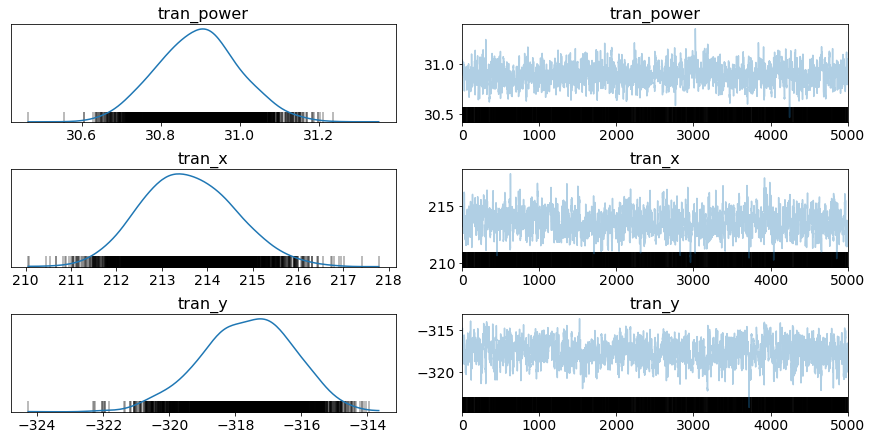

In [47]:
az.plot_trace(fit2, var_names=['tran_power','tran_x','tran_y'])

In [27]:
fit.stansummary()['tran_power']

TypeError: string indices must be integers

In [28]:
fit.get_posterior_mean()

array([[   30.89484228],
       [  213.60483694],
       [ -317.80781036],
       [    8.29471993],
       [   49.74277769],
       [-2835.95959666]])

In [41]:
spectrum_nn.sampling?